# Notebook 3 — Retroalimentación hielo–albedo e histéresis

En el Notebook 2 hemos visto que, con albedo fijo, el modelo responde de forma suave y “reversible” al forzamiento radiativo: si cambiamos F poco a poco, el estado del modelo cambia también poco a poco.

En este Notebook 3 activamos una retroalimentación (feedback) sencilla del modelo unidimensional dependiente de la latitud:

- si una región está fría, se considera que tendrá más hielo/nieve;
- más hielo/nieve implica mayor albedo;
- mayor albedo reduce la energía solar absorbida;
- eso tiende a enfriar todavía más.

Este mecanismo puede producir **dependencia de las condiciones iniciales**: para un mismo valor de F pueden existir **dos estados estables distintos** o **multiestabilidad**, y el estado alcanzado depende de la condición inicial o del camino seguido (lo que en física se conoce como *histéresis*).

Importante: aquí el albedo dependiente de temperatura se aplica como un “control externo” sencillo. No es necesario entender el código interno, pero sí interpretar los resultados.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import climlab

# Opcional: suprimir warnings numéricos puntuales durante algunos cálculos
np.seterr(all='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Cómo se representa el feedback hielo–albedo en este modelo

Para introducir el feedback hielo–albedo, el modelo necesita una forma sencilla de decidir si una región está “cubierta de hielo” o “libre de hielo” en función de la temperatura.

En lugar de introducir un modelo detallado del hielo (que sería muy complejo para esta PED), utilizamos una aproximación sencilla:

- cuando la temperatura es alta, se asume que no hay hielo;
- cuando la temperatura es baja, se asume que hay hielo;
- entre ambos casos, la transición es progresiva.

Para representar esta idea se introduce una **variable auxiliar**, que llamamos **f(T)**, con valores entre 0 y 1:

- f(T) ≈ 0 → región sin hielo
- f(T) ≈ 1 → región completamente cubierta de hielo
- valores intermedios → cobertura parcial

Esta variable no representa un proceso físico, sino una herramienta de modelización que permite conectar la temperatura con el albedo de forma continua.


## Parámetros del feedback hielo–albedo (modificables)

En este notebook hay tres parámetros clave:

- `alpha_ice`: valor (alto) del albedo para las zonas que estén completamente cubiertas por hielo/nieve.
- `Tf`: temperatura umbral (°C) alrededor de la cual aparece/desaparece hielo.
- `deltaT`: 'amplitud' de la transición (°C) entre aparición/desaparición de hielo. 
  Valores pequeños → transición más brusca → mayor probabilidad de histéresis.

En este modelo simplificado no se busca una “calibración realista”. Se pretende observar el fenómeno y reconocer el mecanismo implicado en la multiestabilidad, entendiendo cómo la retroalimentación puede hacer que pequeñas diferencias en parámetros puedan cambiar mucho el comportamiento del sistema.


In [2]:
# Número de años de integración en cada paso del barrido en F
NYEARS_SPINUP = 30

# Activar el feedback hielo–albedo
USE_ICE_ALBEDO = True

# Parámetros hielo–albedo
alpha_ice = 0.60   
Tf = -2.0          # °C
deltaT = 2.5       # °C 


In [3]:
# ============================================================
# 0) Asistente para extraer diagnósticos del estado del modelo
# ============================================================

def model_diagnostics(m, Tf):
    """
  Devuelve un conjunto compacto de diagnósticos de los estados del albedo del hielo. 
    """
    # Temperature field (try common names)
    if hasattr(m, 'Ts'):
        Ts = np.array(m.Ts)
    elif 'Ts' in m.state:
        Ts = np.array(m.state['Ts'])
    elif 'T' in m.state:
        Ts = np.array(m.state['T'])
    else:
        raise ValueError("No se puede encontrar las temperaturas de la superficie (Ts o T) en el modelo.")

    # Fracción de hielo (recalcular a partir de Ts)
    
    f = np.array(smooth_ice_fraction(Ts, Tf=Tf, deltaT=deltaT))
    # Albedo actual del proceso SW
    alpha = np.array(m.subprocess['SW'].albedo)

    diag = {
        'Ts_min': float(np.min(Ts)),
        'Ts_mean': float(np.mean(Ts)),
        'Ts_max': float(np.max(Ts)),
        'fice_min': float(np.min(f)),
        'fice_mean': float(np.mean(f)),
        'fice_max': float(np.max(f)),
        'alpha_min': float(np.min(alpha)),
        'alpha_mean': float(np.mean(alpha)),
        'alpha_max': float(np.max(alpha)),
        'ice_area_fraction_(fice>0.5)': float(np.mean(f > 0.5)),
        'any_ice_(Ts<Tf)': bool(np.any(Ts < Tf)),
    }
    return diag


## Cómo se representa el hielo en este modelo

En este modelo no se simula el hielo de forma explícita.
En su lugar, se introduce una variable auxiliar que representa
la *fracción de hielo* en cada latitud.

- Valor 0: región sin hielo  
- Valor 1: región completamente cubierta de hielo  
- Valores intermedios: cobertura parcial  

Esta fracción depende únicamente de la temperatura local
y cambia de forma suave alrededor de un umbral de congelación.


## Cómo actúa el feedback hielo–albedo

La retroalimentación hielo–albedo se implementa como un *control externo*:

- La temperatura determina la fracción de hielo.
- La fracción de hielo modifica el albedo.
- El nuevo albedo cambia la energía solar absorbida.
- Esto afecta de nuevo a la temperatura.

Este bucle se aplica en cada paso de tiempo del modelo. No representa un proceso físico detallado, sino un
mecanismo conceptual para introducir retroalimentación positiva. 

In [4]:
SECONDS_PER_YEAR = 365.0 * 24.0 * 3600.0

def steps_per_year(model):
    """Número de pasos de tiempo del modelo en un año."""
    dt = float(model.timestep)
    return int(np.round(SECONDS_PER_YEAR / dt))

def smooth_ice_fraction(Tc, Tf=-2.0, deltaT=2.5):
    """
    Fracción de hielo suave f(T) en [0,1].
    f ~ 1 en frío (hielo), f ~ 0 en cálido (sin hielo).
    """
    x = (Tc - Tf) / deltaT
    return 0.5 * (1.0 - np.tanh(x))

def update_sw_albedo_from_temperature(model, alpha_warm_field,
                                      alpha_ice=0.60, Tf=-2.0, deltaT=2.5):
    """
    Control externo del albedo de SW:
        alpha = alpha_warm + (alpha_ice - alpha_warm) * f(T)

    - alpha_warm_field: albedo “de referencia cálido” (depende de latitud)
    - f(T): fracción de hielo según Ts
    """
    Ts = np.array(model.state['Ts'])
    fice = smooth_ice_fraction(Ts, Tf=Tf, deltaT=deltaT)

    alpha_warm = np.array(alpha_warm_field)
    alpha_new = alpha_warm + (alpha_ice - alpha_warm) * fice
    alpha_new = np.clip(alpha_new, 0.0, 1.0)

    # Sustituimos el campo de albedo del subprocess SW preservando la estructura Field
    sw = model.subprocess['SW']
    sw.albedo = sw.albedo * 0.0 + alpha_new

def spinup_model(model, nyears, albedo_controller=None):
    """
    Integra nyears años aplicando (si existe) el controlador del albedo en cada paso.
    """
    nsteps = int(nyears * steps_per_year(model))
    for _ in range(nsteps):
        if albedo_controller is not None:
            albedo_controller()
        model.step_forward()
    return model


## Aplicación consistente del forzamiento

Recordamos que en este modelo el forzamiento se aplica como:

A → A − F  en  OLR = A + B·T

In [6]:
def build_ebm_seasonal(F=0.0):
    """
    Crea un EBM_seasonal nuevo, guarda A0 sin forzamiento y aplica F como A = A0 - F.
    Devuelve: (modelo, alpha_warm_field)
    """
    m = climlab.EBM_seasonal()

    # Guardar A0 sin forzamiento
    m.param['A0_unforced'] = float(m.subprocess['LW'].A)

    # Aplicar forzamiento consistente
    m.subprocess['LW'].A = m.param['A0_unforced'] - F

    # Albedo de referencia cálido (depende de latitud) tomado del SW del modelo base
    alpha_warm = m.subprocess['SW'].albedo.copy()

    return m, alpha_warm

def set_forcing(m, F):
    """Ajusta el forzamiento sin acumulación."""
    A0 = m.param['A0_unforced']
    m.subprocess['LW'].A = A0 - F


## Dependencia del estado final respecto a la condición inicial

En los notebooks anteriores hemos visto que, en muchos casos, el modelo alcanza un mismo peril final independientemente del estado inicial, es decir “olvida” el origen.

Con la retroalimentación hielo–albedo esto puede dejar de ocurrir.

Para comprobarlo, vamos a realizar dos conjuntos de experimentos que se diferencian únicamente en las condiciones inicial desde las que parte el modelo:

1) **Experimento con condición inicial cálida**  
   El modelo parte de un estado climático relativamente cálido y, a partir de ahí, se va ajustando para distintos valores del forzamiento F.

2) **Experimento con condición inicial fría**  
   El modelo parte de un estado climático muy frío (con mucho hielo) y se repite el mismo proceso.

En ambos casos:
- para cada valor de F, el modelo se integra durante varios años hasta alcanzar un régimen estacionario;
- el estado final obtenido se usa como condición inicial del siguiente paso.

El modelo presenta histéresis cuando ambos experimentos dan resultados distintos para un mismo valor de forzamiento.
Esto indica que el estado climático alcanzado depende de la historia previa del sistema.


In [8]:

def run_equilibrium(F, m_initial=None, alpha_warm_field=None,
                    Tf=-2.0, deltaT=2.5, steps=1800, verbose=False):
    """
    Integra el modelo hasta alcanzar un estado estacionario
    para un valor dado del forzamiento radiativo F, aplicando
    el feedback hielo–albedo en cada paso de tiempo.
    
    Devuelve:
    -------
    Tmean : float
    m : climlab model
    diag : dict
    """

    # 1) Construir o reutilizar el modelo
    if m_initial is None:
        m, _alpha_warm_unused = build_ebm_seasonal(F=0.0)
    else:
        m = m_initial

    # 2) Seguridad: se requiere una línea base cálida fija
    if alpha_warm_field is None:
        raise ValueError("Se debe proporcionar alpha_warm_field (albedo de línea base cálido fijo).")

    # 3) Aplicar forzamiento
    set_forcing(m, F)

    # 4) Define el controlador de albedo (usa su oficina suave (T) y escribe en SW.albedo)
    def albedo_controller():
        update_sw_albedo_from_temperature(
            m,
            alpha_warm_field=alpha_warm_field,
            alpha_ice=alpha_ice,
            Tf=Tf,
            deltaT=deltaT
        )

    # 5) Integrar para el número de pasos solicitado
    for _ in range(int(steps)):
        albedo_controller()
        m.step_forward()

    # 6) Diagnostics
    diag = model_diagnostics(m, Tf)
    Tmean = diag["Ts_mean"]

    if verbose:
        print(
            f"F={F:6.2f} | Ts_mean={diag['Ts_mean']:.2f} | Ts_min={diag['Ts_min']:.2f} "
            f"| fice_max={diag['fice_max']:.2f} | ice_area={diag['ice_area_fraction_(fice>0.5)']:.3f} "
            f"| alpha_mean={diag['alpha_mean']:.3f}"
        )

    return Tmean, m, diag


## Dependencia del estado final de la historia del sistema

En presencia de feedbacks positivos, el estado final del sistema
puede depender de la trayectoria seguida y no solo del valor actual
del forzamiento.

Para estudiarlo, realizamos dos experimentos:

- Barrido "up": comenzamos en un estado frío y aumentamos F.
- Barrido "down": comenzamos en un estado cálido y reducimos F.

Si para un mismo valor de F se obtienen estados distintos,
el sistema presenta histéresis.


In [17]:
# ============================================================
# 1) Albedo base cálido fijo (sin hielo)
# Usar el albedo base del modelo devuelto por build_ebm_seasonal()
# ============================================================

m0, alpha_warm_field = build_ebm_seasonal(F=0.0)
print("Campo de albedo de línea base cálido almacenado:",
      float(alpha_warm_field.min()),
      float(alpha_warm_field.mean()),
      float(alpha_warm_field.max()))

# ============================================================
# 2) Barridos (arriba y abajo) usando run_equilibrium
# ============================================================
F_values_up = list(range(-20, 60, 5)) 
F_values_down = list(range(55, -25, -5)) 

T_up = []
diag_up = []
m_prev = None

for F in F_values_up:
    Tmean, m_prev, diag = run_equilibrium(
        F, m_initial=m_prev,
        alpha_warm_field=alpha_warm_field,
        Tf=Tf, deltaT=deltaT,
        steps=1800, verbose=True
    )
    T_up.append(Tmean)
    diag_up.append(diag)

T_down = []
diag_down = []
m_prev = None

for F in F_values_down:
    Tmean, m_prev, diag = run_equilibrium(
        F, m_initial=m_prev,
        alpha_warm_field=alpha_warm_field,
        Tf=Tf, deltaT=deltaT,
        steps=1800, verbose=True
    )
    T_down.append(Tmean)
    diag_down.append(diag)


Warm baseline albedo field stored: 0.20511421993391957 0.39249999999999996 0.5798857800660805
F=-20.00 | Ts_mean=-49.54 | Ts_min=-63.78 | fice_max=1.00 | ice_area=1.000 | alpha_mean=0.600
F=-15.00 | Ts_mean=-47.04 | Ts_min=-61.28 | fice_max=1.00 | ice_area=1.000 | alpha_mean=0.600
F=-10.00 | Ts_mean=-44.54 | Ts_min=-58.78 | fice_max=1.00 | ice_area=1.000 | alpha_mean=0.600
F= -5.00 | Ts_mean=-42.04 | Ts_min=-56.28 | fice_max=1.00 | ice_area=1.000 | alpha_mean=0.600
F=  0.00 | Ts_mean=-39.54 | Ts_min=-53.78 | fice_max=1.00 | ice_area=1.000 | alpha_mean=0.600
F=  5.00 | Ts_mean=-37.04 | Ts_min=-51.28 | fice_max=1.00 | ice_area=1.000 | alpha_mean=0.600
F= 10.00 | Ts_mean=-34.54 | Ts_min=-48.78 | fice_max=1.00 | ice_area=1.000 | alpha_mean=0.600
F= 15.00 | Ts_mean=-32.04 | Ts_min=-46.28 | fice_max=1.00 | ice_area=1.000 | alpha_mean=0.600
F= 20.00 | Ts_mean=-29.54 | Ts_min=-43.78 | fice_max=1.00 | ice_area=1.000 | alpha_mean=0.600
F= 25.00 | Ts_mean=-27.04 | Ts_min=-41.28 | fice_max=1.00 | 

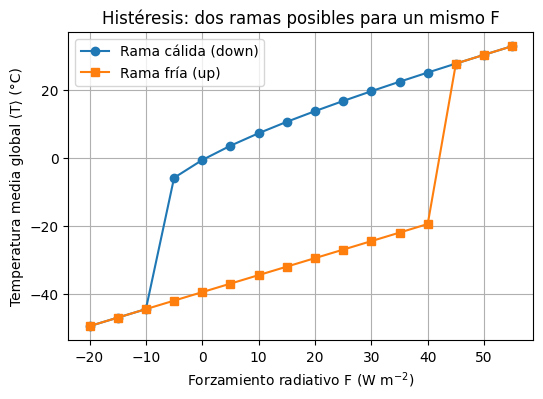

In [18]:
plt.figure(figsize=(6,4))
plt.plot(F_values_down, T_down, 'o-', label='Rama cálida (down)')
plt.plot(F_values_up,   T_up,   's-', label='Rama fría (up)')
plt.xlabel('Forzamiento radiativo F (W m$^{-2}$)')
plt.ylabel('Temperatura media global ⟨T⟩ (°C)')
plt.title('Histéresis: dos ramas posibles para un mismo F')
plt.grid(True)
plt.legend()
plt.show()


## Interpretación de resultados

La figura muestra dos ramas distintas para un mismo valor
del forzamiento radiativo:

- Rama fría: el sistema permanece cubierto de hielo.
- Rama cálida: el hielo ha desaparecido y el albedo es menor.

Esto indica que el sistema tiene múltiples estados estables
y que el estado alcanzado depende de la historia previa.
Este comportamiento es característico de sistemas con
retroalimentación positiva fuerte.
